<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled215.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install gemmi

— DIAGNOSTIC —
Metals (expect Ca + 4 Mn): ['Ca', 'Mn', 'Mn', 'Mn', 'Mn']
Inter-metal distances (Å):
  Ca-Mn: 3.49
  Ca-Mn: 3.30
  Ca-Mn: 3.41
  Ca-Mn: 3.80
  Mn-Mn: 2.76
  Mn-Mn: 3.29
  Mn-Mn: 4.92
  Mn-Mn: 2.92
  Mn-Mn: 5.38
  Mn-Mn: 2.89
μ-O selected: 4  (Mn–O≤2.35 Å, Ca–O≤2.70 Å)
  O1: [('Mn', '1.93'), ('Mn', '2.02'), ('Mn', '1.86')]
  O2: [('Ca', '2.44'), ('Mn', '1.80'), ('Mn', '2.07')]
  O3: [('Ca', '2.48'), ('Mn', '1.96'), ('Mn', '1.91')]
  O4: [('Ca', '2.57'), ('Mn', '2.25'), ('Mn', '2.34')]
Waters: ['W1', 'W2', 'W3', 'W4']


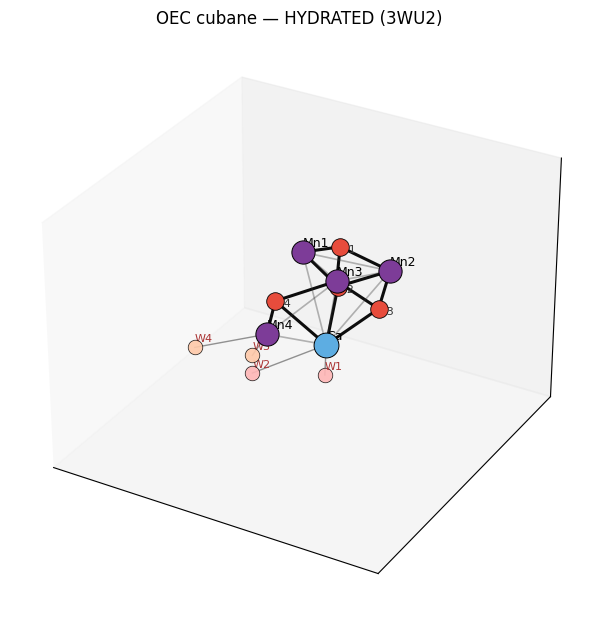

✅ Saved OEC_cubane_overview.png


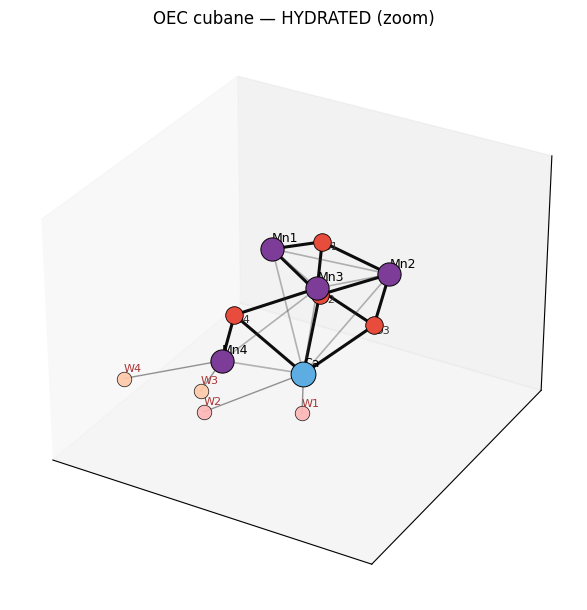

✅ Saved OEC_cubane_zoom.png


In [ ]:
# ================================================================
# OEC cubane from 3WU2.cif — robust μ-oxo detection + W1–W4 split
# Overview + Zoom panels; clean diagnostics
# ================================================================
import os, math, numpy as np, matplotlib.pyplot as plt

try:
    import gemmi
except ModuleNotFoundError as e:
    raise ModuleNotFoundError(
        "gemmi is required. In Colab run:\n  !pip -q install gemmi\nthen rerun this cell."
    )

# -------------------- USER SETTINGS --------------------
CIF_FILE   = "3WU2.cif"       # upload first
OUT_OV     = "OEC_cubane_overview.png"
OUT_ZOOM   = "OEC_cubane_zoom.png"
ZOOM_R     = 4.0              # Å radius around metal centroid
W_ANY_MAX  = 3.2              # Å water → any metal shortlist
W_CA_BIND  = 2.60             # Å W1/W2 Ca-bound cutoff
W_CA_FAR   = 3.2              # Å W3/W4 must be ≥ this far from Ca

# -------------------- HELPERS --------------------
def P(a): p=a.pos; return np.array([p.x, p.y, p.z], float)
def d(a,b): return float(np.linalg.norm(P(a)-P(b)))

def set_equal(ax, pts, pad=0.8):
    pts = np.asarray(pts); cx,cy,cz = pts.mean(axis=0)
    span = np.max(np.ptp(pts, axis=0))
    r = span * 0.65 + pad
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

def draw_bond(ax, A, B, color="k", lw=2.0, alpha=0.95):
    ax.plot([A[0],B[0]],[A[1],B[1]],[A[2],B[2]], color=color, lw=lw, alpha=alpha)

# -------------------- LOAD STRUCTURE --------------------
if not os.path.exists(CIF_FILE):
    raise FileNotFoundError(f"Upload {CIF_FILE} first.")

st = gemmi.read_structure(CIF_FILE)
st.remove_hydrogens()
model = st[0]

Mn_all, Ca_all, O_all, W_all = [], [], [], []
for ch in model:
    for res in ch:
        is_w = res.name.upper() in ("HOH","WAT","H2O","DOD","W")
        for a in res:
            el = a.element.name.upper()
            if el == "MN": Mn_all.append(a)
            elif el == "CA": Ca_all.append(a)
            elif el.startswith("O"):
                (W_all if is_w else O_all).append(a)

if len(Mn_all) < 4 or len(Ca_all) < 1:
    raise RuntimeError("Could not find at least 4×Mn and 1×Ca in the file.")

# -------------------- PICK Ca + Mn4 (same asymmetric unit) --------------------
Mn_xyz = np.array([P(a) for a in Mn_all], float)

# Ca atoms reasonably near any Mn (same crystal image)
Ca_near = [a for a in Ca_all if np.min(np.linalg.norm(Mn_xyz - P(a), axis=1)) < 6.0]
if not Ca_near:
    raise RuntimeError("No Ca within 6 Å of any Mn — check CIF symmetry or file path.")

def cubane_cost(mset, Ca_atom):
    pts = np.array([P(m) for m in mset])
    pair = sum(np.linalg.norm(pts[i]-pts[j]) for i in range(4) for j in range(i+1,4))
    cen  = pts.mean(axis=0)
    d_ca = np.linalg.norm(cen - P(Ca_atom))
    return pair + 2.5*d_ca  # weight Ca proximity

best_combo, best_cost = None, 1e9
from itertools import combinations
for Ca_atom in Ca_near:
    for combo in combinations(Mn_all, 4):
        cst = cubane_cost(combo, Ca_atom)
        if cst < best_cost:
            best_cost = cst
            best_combo = (Ca_atom, combo)

Ca1, Mn4 = best_combo
Mn4 = list(Mn4)
metals = [Ca1] + Mn4
met_pts = [P(m) for m in metals]

# -------------------- μ-OXO PICKER (prefer ≥3-bridging) --------------------
def pick_mu_oxo(oxy_atoms, metals, thr_mn_o=2.20, thr_ca_o=2.55, widen=0.05, max_mn=2.40, max_ca=2.70):
    def neighbors(o, t_mn, t_ca):
        nb = []
        for m in metals:
            dm = d(o, m)
            if (m.element.name.upper() == "MN" and dm <= t_mn) or \
               (m.element.name.upper() == "CA" and dm <= t_ca):
                nb.append((m, dm))
        return nb

    t_mn, t_ca = thr_mn_o, thr_ca_o
    while True:
        candidates = []
        for o in oxy_atoms:
            nb = neighbors(o, t_mn, t_ca)
            if len(nb) >= 2:
                deg = len(nb)
                tot = sum(dm for _, dm in nb)
                candidates.append((o, deg, tot))
        # prefer degree ≥3 first
        deg3 = [c for c in candidates if c[1] >= 3]
        pick_from = sorted(deg3, key=lambda x: (-x[1], x[2])) if deg3 \
                    else sorted(candidates, key=lambda x: (-x[1], x[2]))

        if len(pick_from) >= 4:
            return [c[0] for c in pick_from[:4]], t_mn, t_ca

        if t_mn + widen <= max_mn or t_ca + widen <= max_ca:
            t_mn = min(max_mn, t_mn + widen)
            t_ca = min(max_ca, t_ca + widen)
        else:
            return [c[0] for c in pick_from], t_mn, t_ca

muO, thr_mn_o, thr_ca_o = pick_mu_oxo(O_all, metals)
if len(muO) < 4:
    raise RuntimeError(f"Only found {len(muO)} μ-oxo (Mn–O≤{thr_mn_o:.2f}, Ca–O≤{thr_ca_o:.2f}).")

# -------------------- WATER CLASSIFICATION (W1/W2 vs W3/W4) --------------------
def classify_waters(waters, metals, Ca_atom, max_any=3.2, ca_bind=2.60, far_from_ca=3.2):
    close = [w for w in waters if min(d(w, m) for m in metals) <= max_any]
    ca_w  = sorted([w for w in close if d(w, Ca_atom) <= ca_bind], key=lambda w: d(w, Ca_atom))[:2]
    Mn_only = []
    for w in close:
        if w in ca_w:
            continue
        if d(w, Ca_atom) >= far_from_ca and any(m.element.name.upper()=="MN" and d(w,m) <= max_any for m in metals):
            Mn_only.append(w)
    chosen = []
    for w in sorted(Mn_only, key=lambda w: min(d(w,m) for m in metals if m.element.name.upper()=="MN")):
        if all(d(w, x) >= 1.2 for x in chosen):
            chosen.append(w)
        if len(chosen) == 2:
            break
    return ca_w, chosen

W_ca, W_mn = classify_waters(W_all, metals, Ca1, max_any=W_ANY_MAX, ca_bind=W_CA_BIND, far_from_ca=W_CA_FAR)
W = W_ca + W_mn
W_labels = {}
if len(W_ca) >= 1: W_labels[id(W_ca[0])] = "W1"
if len(W_ca) >= 2: W_labels[id(W_ca[1])] = "W2"
if len(W_mn) >= 1: W_labels[id(W_mn[0])] = "W3"
if len(W_mn) >= 2: W_labels[id(W_mn[1])] = "W4"

# -------------------- EDGES --------------------
# metal–μO
M_O_edges = []
for i, m in enumerate(metals):
    thr = thr_ca_o if m.element.name.upper()=="CA" else thr_mn_o
    for j, o in enumerate(muO):
        if d(m, o) <= thr:
            M_O_edges.append((i, j))

# metal–metal edge if they share at least one μ-O
MM_edges = set()
for i, j in combinations(range(len(metals)), 2):
    shared = any( ((i,k) in M_O_edges) and ((j,k) in M_O_edges) for k in range(len(muO)) )
    if shared:
        MM_edges.add((i, j))

# -------------------- DIAGNOSTIC --------------------
def tag(a):
    el = a.element.name
    sid = getattr(a, "serial", None)
    return f"{el}{'' if sid is None else ':'+str(sid)}"

print("— DIAGNOSTIC —")
print("Metals (expect Ca + 4 Mn):", [m.element.name for m in metals])
print("Inter-metal distances (Å):")
for i in range(len(metals)):
    for j in range(i+1, len(metals)):
        print(f"  {metals[i].element.name}-{metals[j].element.name}: {d(metals[i], metals[j]):.2f}")
print(f"μ-O selected: {len(muO)}  (Mn–O≤{thr_mn_o:.2f} Å, Ca–O≤{thr_ca_o:.2f} Å)")
for k, o in enumerate(muO, 1):
    nb = []
    for m in metals:
        dd = d(o, m)
        if (m.element.name.upper()=="MN" and dd<=thr_mn_o) or (m.element.name.upper()=="CA" and dd<=thr_ca_o):
            nb.append((m.element.name, f"{dd:.2f}"))
    print(f"  O{k}: {nb}")
print("Waters:", [W_labels.get(id(w), '?') for w in W])

# -------------------- DRAW --------------------
COL = {"MN":"#7D3C98", "CA":"#5DADE2", "O_MU":"#E74C3C", "W_CA":"#FFB6B6", "W_MN":"#FFC9A9"}
SZ  = {"MN":280, "CA":320, "O_MU":160, "W_CA":110, "W_MN":110}

def draw(ax, metals, muO, waters, title, W_ca, W_labels, zoom=None):
    pts = []
    # metals
    for idx, m in enumerate(metals):
        X = P(m); E = m.element.name.upper()
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ[E], c=COL[E], ec="k", lw=0.7)
        ax.text(X[0], X[1], X[2]+0.22, "Ca" if E=="CA" else f"Mn{idx}", fontsize=9)
        pts.append(X)
    # μ-oxo
    for j, o in enumerate(muO, 1):
        X = P(o)
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ["O_MU"], c=COL["O_MU"], ec="k", lw=0.6)
        ax.text(X[0], X[1], X[2]-0.28, f"O{j}", fontsize=8, color="#333")
        pts.append(X)
    # bonds M–O
    for i, j in M_O_edges:
        draw_bond(ax, P(metals[i]), P(muO[j]), "k", 2.2, 0.95)
    # cubane MM (light)
    for i, j in MM_edges:
        draw_bond(ax, P(metals[i]), P(metals[j]), "#333", 1.2, 0.35)
    # waters
    def nearest_metal(pt):
        mm = min(metals, key=lambda m: np.linalg.norm(P(m)-pt))
        return mm, np.linalg.norm(P(mm)-pt)

    for w in waters:
        X = P(w)
        is_ca_side = any(id(w) == id(x) for x in W_ca)
        key = "W_CA" if is_ca_side else "W_MN"
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ[key], c=COL[key], ec="k", lw=0.5, alpha=0.9)
        ax.text(X[0], X[1], X[2]+0.22, W_labels.get(id(w), "W"), fontsize=8, color="#a33")
        m_near, dnm = nearest_metal(X)
        if dnm <= 2.5:
            draw_bond(ax, X, P(m_near), "#666", 1.0, 0.7)
        pts.append(X)

    ax.set_title(title)
    if zoom is None:
        set_equal(ax, pts)
    else:
        cx, cy, cz, r = zoom
        ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# Overview
fig = plt.figure(figsize=(7.8, 6.3))
ax  = fig.add_subplot(111, projection='3d')
draw(ax, metals, muO, W, "OEC cubane — HYDRATED (3WU2)", W_ca, W_labels, zoom=None)
plt.tight_layout(); plt.savefig(OUT_OV, dpi=300); plt.show()
print("✅ Saved", OUT_OV)

# Zoom
cen = np.mean(np.array([P(m) for m in metals]), axis=0)
fig2 = plt.figure(figsize=(6.6, 6.2))
ax2  = fig2.add_subplot(111, projection='3d')
draw(ax2, metals, muO, W, "OEC cubane — HYDRATED (zoom)", W_ca, W_labels,
     zoom=(cen[0], cen[1], cen[2], ZOOM_R))
plt.tight_layout(); plt.savefig(OUT_ZOOM, dpi=300); plt.show()
print("✅ Saved", OUT_ZOOM)

In [ ]:
!pip -q install cupy-cuda12x imageio imageio-ffmpeg

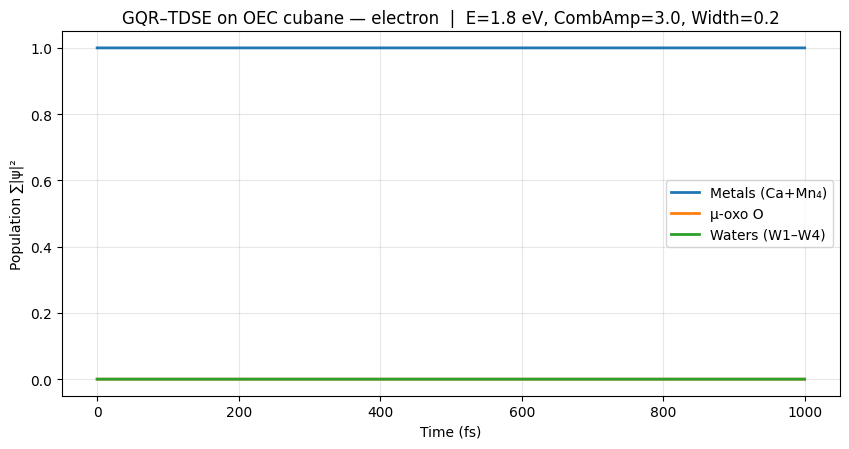

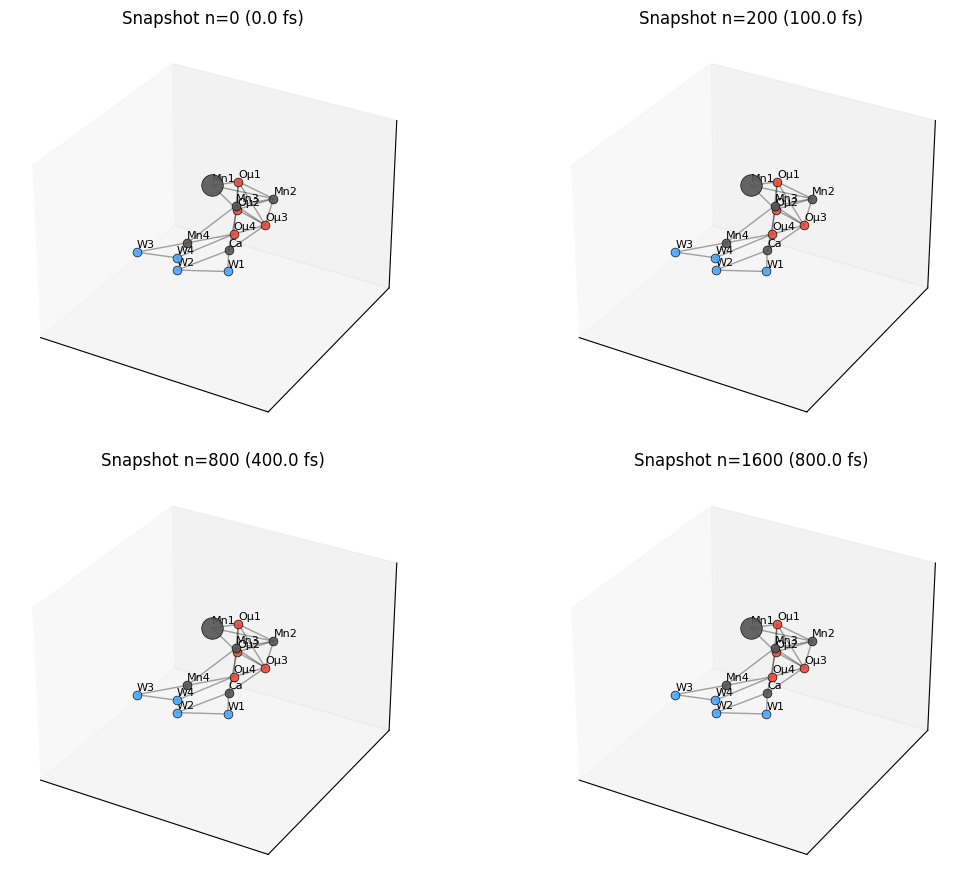

N nodes: 13
Labels: ['Ca', 'Mn1', 'Mn2', 'Mn3', 'Mn4', 'Oμ1', 'Oμ2', 'Oμ3', 'Oμ4', 'W1', 'W2', 'W3', 'W4']
Groups: ['metal', 'metal', 'metal', 'metal', 'metal', 'mu-oxo', 'mu-oxo', 'mu-oxo', 'mu-oxo', 'water', 'water', 'water', 'water']


In [ ]:
# [001] ================================================================
# [002] OEC (3WU2.cif) → GQR–TDSE tunnelling on CaMn4O5 + 4 waters
# [003] - Extract Ca + Mn4 + μ-oxo bridges + 4 near waters
# [004] - Build GQR-modified Hamiltonian on the graph
# [005] - Time-propagate ψ(t) with eigen-decomposition at each step
# [006] - Plots: group populations vs time, and 3D snapshots
# [007] ================================================================
# [008] Colab note: upload 3WU2.cif (dark-adapted S1) to the runtime first.
# [009]
# [010] Dependencies: numpy, matplotlib, gemmi
# [011] ================================================================
!pip -q install gemmi

# [015] ---------- Imports ----------
import os, numpy as np, matplotlib.pyplot as plt, gemmi
from itertools import combinations

# [020] ---------- User controls ----------
CIF_PATH   = "3WU2.cif"   # upload beforehand
SPECIES    = 'e'          # 'e' for electron, 'H' for proton
E_eV       = 1.8          # driving "field/energy" level (physiological upper ~1.8 eV)
DT         = 0.5e-15      # time step (s) ~0.5 fs
NSTEPS     = 2000         # number of time-steps
SNAP_STEPS = [0, 200, 800, 1600]   # frames to snapshot in 3D

# [030] GQR knobs (tune as you like)
COMB_AMP    = 3.0         # 1–5 reasonable in OEC discussions
COMB_WIDTH  = 0.20        # 0.1–0.3 Å typical
ALPHA_SH    = 0.14        # shield loss baseline
D0_SH       = 0.8         # Å
P_SH        = 2.0
DUTY_MAX_e  = 1.9         # hydrated duty limit — electrons
DUTY_MAX_H  = 2.1         # hydrated duty limit — protons
ETA_MAX_e   = 0.30        # aperture cap — electrons
ETA_MAX_H   = 0.38        # aperture cap — protons
SIG_E0_e    = 0.30        # sigmoid center for e-
SIG_E0_H    = 0.45        # sigmoid center for H
SIG_K_e     = 4.0         # sigmoid steepness
SIG_K_H     = 3.5

# [045] Baseline tunnelling prefactors/decays (slower for H)
R0_e, BETA_e = 1.68e11, 0.64
R0_H, BETA_H = 9.42e3,  0.77
T0_e, T0_H   = 1.0,     1.0    # overall coupling scales (unitless here)

# [050] ---------- Helpers ----------
def P(a):
    p=a.pos; return np.array([p.x, p.y, p.z], float)

def set_equal(ax, pts, pad=0.8):
    pts = np.asarray(pts); cx,cy,cz = pts.mean(axis=0)
    r = max(np.ptp(pts, axis=0)) * 0.65 + pad
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

def dist(a,b): return float(np.linalg.norm(a-b))

def lorentzian(d, c, g): return (g*g)/((d-c)**2 + g*g)

def resonance_comb(d, amp, width, centers=(0.7, 1.0, 1.5, 2.2), taper_len=3.0):
    s = 0.0
    for c in centers: s += lorentzian(d, c, width)
    s = s / (s if np.isscalar(s) else (np.max(s)+1e-12))
    taper = np.exp(-d / taper_len)
    return 1.0 + amp * s * taper

def shield_loss(d, alpha, d0, p):
    S = 1.0 - alpha*np.exp(-(d/d0)**p)
    return np.clip(S, 1e-6, 1.0)

def sigmoid(x, x0, k): return 1.0/(1.0 + np.exp(-k*(x-x0)))

# [085] ---------- Load CIF and select cubane + waters ----------
if not os.path.exists(CIF_PATH):
    raise FileNotFoundError("Upload 3WU2.cif first (dark-adapted S1 state).")

st = gemmi.read_structure(CIF_PATH)
st.remove_hydrogens()
model = st[0]

Mn_all, Ca_all, O_all, Wat_all = [], [], [], []
for ch in model:
    for res in ch:
        is_w = res.name.upper() in ("HOH","WAT","H2O","DOD","W")
        for a in res:
            e = a.element.name.upper()
            if e == "MN": Mn_all.append(a)
            elif e == "CA": Ca_all.append(a)
            elif e.startswith("O"):
                (Wat_all if is_w else O_all).append(a)

if len(Mn_all) < 4 or len(Ca_all) < 1:
    raise RuntimeError("Could not find Ca + ≥4 Mn in 3WU2.cif")

Mn_xyz = np.array([P(a) for a in Mn_all])
# pick Ca near Mn cluster (same asym unit)
Ca_near = [a for a in Ca_all if np.min(np.linalg.norm(Mn_xyz - P(a), axis=1)) < 6.0]
if not Ca_near:
    # fallback: just nearest Ca to Mn centroid
    cen = Mn_xyz.mean(axis=0)
    Ca_near = [min(Ca_all, key=lambda a: np.linalg.norm(P(a)-cen))]

def cubane_cost(mset, Ca_atom):
    pts = np.array([P(m) for m in mset])
    pair = sum(np.linalg.norm(pts[i]-pts[j]) for i in range(4) for j in range(i+1,4))
    cen  = pts.mean(axis=0)
    d_ca = np.linalg.norm(cen - P(Ca_atom))
    return pair + 2.5*d_ca

best_combo, best_cost = None, 1e9
for Ca_atom in Ca_near:
    for combo in combinations(Mn_all, 4):
        cst = cubane_cost(combo, Ca_atom)
        if cst < best_cost:
            best_cost = cst
            best_combo = (Ca_atom, combo)

Ca1, Mn4 = best_combo
Mn4 = list(Mn4)
metals = [Ca1] + Mn4
met_pts = [P(m) for m in metals]

# μ-oxo search with adaptive cutoffs
thr_mn_o, thr_ca_o = 2.20, 2.55
def find_mu_oxo(O_list, metals, t_mn, t_ca):
    found=[]
    for o in O_list:
        po = P(o)
        neighbors=[]
        for m in metals:
            dm = np.linalg.norm(po - P(m))
            if (m.element.name.upper()=="MN" and dm<=t_mn) or \
               (m.element.name.upper()=="CA" and dm<=t_ca):
                neighbors.append((m, dm))
        if len(neighbors) >= 2:
            tot = sum(d for _,d in neighbors)
            found.append((o, len(neighbors), tot))
    found.sort(key=lambda t: (-t[1], t[2]))
    return [t[0] for t in found]

muO = find_mu_oxo(O_all, metals, thr_mn_o, thr_ca_o)
while len(muO) < 4 and thr_mn_o < 2.40:
    thr_mn_o += 0.05; thr_ca_o += 0.05
    muO = find_mu_oxo(O_all, metals, thr_mn_o, thr_ca_o)
muO = muO[:4]

# waters: nearest to Ca, within 3.0 Å to any metal
cand=[]
for w in Wat_all:
    pw = P(w)
    if min(np.linalg.norm(pw - P(m)) for m in metals) <= 3.0:
        cand.append((w, np.linalg.norm(pw - P(Ca1))))
cand.sort(key=lambda t: t[1])
W4 = [t[0] for t in cand[:4]]

# [170] ---------- Build node list ----------
nodes = []
labels = []
groups = []  # 'metal','mu-oxo','water'
# metals
for i,m in enumerate(metals):
    nodes.append(P(m))
    labels.append('Ca' if i==0 else f'Mn{i}')
    groups.append('metal')
# mu-oxo
for j,o in enumerate(muO,1):
    nodes.append(P(o))
    labels.append(f'Oμ{j}')
    groups.append('mu-oxo')
# waters
for k,w in enumerate(W4,1):
    nodes.append(P(w))
    labels.append(f'W{k}')
    groups.append('water')

nodes = np.array(nodes)   # shape (N,3)
N = len(nodes)
idx_metal  = [i for i,g in enumerate(groups) if g=='metal']
idx_muoxo  = [i for i,g in enumerate(groups) if g=='mu-oxo']
idx_water  = [i for i,g in enumerate(groups) if g=='water']

# [195] ---------- Species parameters ----------
if SPECIES == 'e':
    beta0, R0, T0 = BETA_e, R0_e, T0_e
    ETA_MAX, SIG_E0, SIG_K = ETA_MAX_e, SIG_E0_e, SIG_K_e
    DUTY_MAX = DUTY_MAX_e
    color = 'darkorange'
else:
    beta0, R0, T0 = BETA_H, R0_H, T0_H
    ETA_MAX, SIG_E0, SIG_K = ETA_MAX_H, SIG_E0_H, SIG_K_H
    DUTY_MAX = DUTY_MAX_H
    color = 'royalblue'

# [210] ---------- GQR parameter maps (edge-length dependent) ----------
def edge_modulators(r, psi_edge_strength):
    """Return (beta_eff, duty, shield, comb) for an edge of length r.
       psi_edge_strength (0..1) weakens shield loss when occupancy builds.
    """
    etaH  = ETA_MAX * sigmoid(E_eV, SIG_E0, SIG_K) if E_eV>0 else 0.0
    duty  = 1.0 + (DUTY_MAX-1.0)*sigmoid(E_eV, SIG_E0, SIG_K) if E_eV>0 else 1.0
    beta_eff = max(beta0*(1.0-etaH), 0.20)
    # feedback: reduce alpha with occupancy
    alpha_eff = ALPHA_SH * (1.0 - 0.5*psi_edge_strength)
    shield = shield_loss(r, alpha=alpha_eff, d0=D0_SH, p=P_SH)
    comb   = resonance_comb(r, COMB_AMP, COMB_WIDTH)
    return beta_eff, duty, shield, comb

# [230] ---------- Build Hamiltonian at a given ψ (feedback on shield) ----------
def build_H(psi):
    # edge "occupancy": use pairwise |psi_i||psi_j| normalized
    amp = np.abs(psi)
    if amp.max() <= 0: occ_scale = np.zeros((N,N))
    else:
        occ_scale = np.outer(amp, amp) / (amp.max()**2 + 1e-15)

    H = np.zeros((N,N), complex)
    for i in range(N):
        for j in range(i+1, N):
            r_ij = np.linalg.norm(nodes[i]-nodes[j])
            if r_ij < 0.5 or r_ij > 6.0:
                continue  # only couple chemically plausible distances
            # base tunnelling decay
            # GQR gain multiplies relative to the bare exp(-βr)
            beta_eff, duty, shield, comb = edge_modulators(r_ij, occ_scale[i,j])
            gain  = np.exp((beta0 - beta_eff)*r_ij) * comb * shield * duty
            t_ij = T0 * np.exp(-beta0*r_ij) * gain
            H[i,j] = t_ij
            H[j,i] = np.conj(t_ij)
    # zero onsite energies (you can add site terms if desired)
    return H

# [260] ---------- TDSE propagator ----------
ħ = 1.054571817e-34  # J*s (unused if we run in scaled units)
# We'll treat H as in arbitrary energy units and use dt as scaled time.
# The per-step evolution uses eigendecomposition of H(ψ_t).

def step_tdse(psi, dt):
    H = build_H(psi)
    # Hermitian by construction; eigh returns real eigenvals
    E, V = np.linalg.eigh(H)
    Udt = V @ np.diag(np.exp(-1j * E * dt)) @ V.conj().T
    psi_next = Udt @ psi
    # renormalize
    psi_next /= np.linalg.norm(psi_next) + 1e-15
    return psi_next

# [280] ---------- Initial state: localized on Mn1 (or Ca) ----------
psi = np.zeros(N, complex)
# Start on Mn1 (index 1 in the metals block [Ca,Mn1,Mn2,Mn3,Mn4])
start_idx = 1
psi[start_idx] = 1.0

# [290] ---------- Simulate ----------
t_arr = np.arange(NSTEPS)*DT
pop_metal = []
pop_muoxo = []
pop_water = []
snaps = {}

for n in range(NSTEPS):
    amp2 = np.abs(psi)**2
    pop_metal.append(amp2[idx_metal].sum())
    pop_muoxo.append(amp2[idx_muoxo].sum())
    pop_water.append(amp2[idx_water].sum())
    if n in SNAP_STEPS:
        snaps[n] = amp2.copy()
    psi = step_tdse(psi, DT)

pop_metal  = np.array(pop_metal)
pop_muoxo  = np.array(pop_muoxo)
pop_water  = np.array(pop_water)

# [315] ---------- Plots ----------
# A) Populations vs time
plt.figure(figsize=(8.6,4.6))
plt.plot(t_arr*1e15, pop_metal,  label='Metals (Ca+Mn₄)', lw=2.0)
plt.plot(t_arr*1e15, pop_muoxo, label='μ-oxo O', lw=2.0)
plt.plot(t_arr*1e15, pop_water, label='Waters (W1–W4)', lw=2.0)
plt.xlabel('Time (fs)')
plt.ylabel('Population ∑|ψ|²')
plt.title(f'GQR–TDSE on OEC cubane — {("electron" if SPECIES=="e" else "proton")}  |  E={E_eV} eV, CombAmp={COMB_AMP}, Width={COMB_WIDTH}')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# B) 3D snapshots
def draw_snapshot(ax, amp2, title):
    # normalize amplitudes for marker scaling
    s = 200 * (amp2 / (amp2.max() + 1e-15)) + 40
    # colors by group
    cols=[]
    for g in groups:
        if g=='metal': cols.append('#555555')
        elif g=='mu-oxo': cols.append('#E74C3C')
        else: cols.append('#4DA6FF')
    for i in range(N):
        x,y,z = nodes[i]
        ax.scatter([x],[y],[z], s=s[i], c=cols[i], ec='k', lw=0.5, alpha=0.9)
        ax.text(x,y,z+0.25, labels[i], fontsize=8)
    # draw heuristic edges for “chemically plausible” connections
    for i in range(N):
        for j in range(i+1,N):
            r = np.linalg.norm(nodes[i]-nodes[j])
            if r <= 3.2:  # show near-neighbor edges
                xi,yi,zi = nodes[i]; xj,yj,zj = nodes[j]
                ax.plot([xi,xj],[yi,yj],[zi,zj], color='k', lw=1.0, alpha=0.35)
    ax.set_title(title)
    set_equal(ax, nodes)

fig = plt.figure(figsize=(12,9))
rows = int(np.ceil(len(SNAP_STEPS)/2))
for k,n in enumerate(SNAP_STEPS, start=1):
    ax = fig.add_subplot(rows,2,k, projection='3d')
    draw_snapshot(ax, snaps[n], f"Snapshot n={n} ({t_arr[n]*1e15:.1f} fs)")
plt.tight_layout()
plt.show()

# [370] ---------- Simple textual diagnostics ----------
print("N nodes:", N)
print("Labels:", labels)
print("Groups:", groups)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✓ DONE: e_E0.0_ch1  →  /content/drive/MyDrive/TDSE_OEC_overnight/OEC_S1_channels/e_E0.0_ch1


✓ DONE: e_E0.0_ch2  →  /content/drive/MyDrive/TDSE_OEC_overnight/OEC_S1_channels/e_E0.0_ch2


✓ DONE: e_E0.6_ch1  →  /content/drive/MyDrive/TDSE_OEC_overnight/OEC_S1_channels/e_E0.6_ch1


✓ DONE: e_E0.6_ch2  →  /content/drive/MyDrive/TDSE_OEC_overnight/OEC_S1_channels/e_E0.6_ch2


✓ DONE: e_E1.8_ch1  →  /content/drive/MyDrive/TDSE_OEC_overnight/OEC_S1_channels/e_E1.8_ch1


✓ DONE: e_E1.8_ch2  →  /content/drive/MyDrive/TDSE_OEC_overnight/OEC_S1_channels/e_E1.8_ch2


⏸ Interrupted by user; progress saved.


✓ DONE: H_E0.0_ch2  →  /content/drive/MyDrive/TDSE_OEC_overnight/OEC_S1_channels/H_E0.0_ch2


✓ DONE: H_E0.6_ch1  →  /content/drive/MyDrive/TDSE_OEC_overnight/OEC_S1_channels/H_E0.6_ch1


✓ DONE: H_E0.6_ch2  →  /content/drive/MyDrive/TDSE_OEC_overnight/OEC_S1_channels/H_E0.6_ch2


✓ DONE: H_E1.8_ch1  →  /content/drive/MyDrive/TDSE_OEC_overnight/OEC_S1_channels/H_E1.8_ch1


✓ DONE: H_E1.8_ch2  →  /content/drive/MyDrive/TDSE_OEC_overnight/OEC_S1_channels/H_E1.8_ch2
📄 Manifest written: /content/drive/MyDrive/TDSE_OEC_overnight/OEC_S1_channels/manifest.txt
⏱ Total wall time: 8.5 min


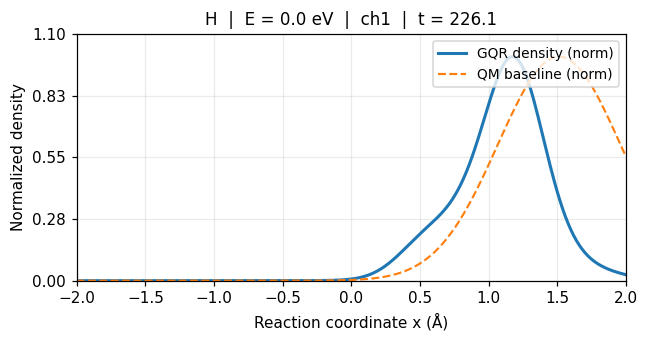

In [ ]:
# ================================================================
# RESUME-READY OVERNIGHT TDSE/GQR RUNNER (Colab-safe)
# - Mounts Google Drive
# - Writes checkpoints so long jobs can RESUME after disconnects
# - Saves NPZ snapshots incrementally + MP4s for each combo
# - Prints a manifest at the end
# ================================================================

import os, json, time, math, shutil, sys
import numpy as np
import matplotlib.pyplot as plt

# Optional: video writing
try:
    import imageio.v2 as imageio
except Exception:
    !pip -q install imageio imageio-ffmpeg
    import imageio.v2 as imageio

# ---------- 1) MOUNT DRIVE (Colab) ----------
try:
    from google.colab import drive  # will error if not in Colab
    drive.mount('/content/drive', force_remount=False)
    BASE_OUT = "/content/drive/MyDrive/TDSE_OEC_overnight"
except Exception:
    # Fallback to local FS (e.g., plain Jupyter)
    BASE_OUT = os.path.abspath("./TDSE_OEC_overnight")

os.makedirs(BASE_OUT, exist_ok=True)

# ---------- 2) CONFIG ----------
CONFIG = {
    "run_name": "OEC_S1_channels",
    # Use whatever channel identifiers you want; these are just labels
    "channels": ["ch1", "ch2"],
    # Species to sweep
    "species": ["e", "H"],
    # Driving voltages (eV) to sweep
    "eV_list": [0.0, 0.6, 1.8],
    # Time grid (choose better stamps if you want slower/faster movies)
    "t_start": 0.0,
    "t_end": 250.0,         # fs (arbitrary units; adapt to your solver)
    "n_steps": 200,         # total frames per combo
    # Save safety (write small NPZ every k steps so you don’t lose much on drop)
    "save_every": 20,
    # MP4 settings
    "fps": 12,
    "dpi": 110,
    # Spatial grid for the placeholder visual (replace with your solver’s output)
    "x_min": -2.0, "x_max": 2.0, "nx": 400
}

RUN_DIR = os.path.join(BASE_OUT, CONFIG["run_name"])
os.makedirs(RUN_DIR, exist_ok=True)
CKPT_PATH = os.path.join(RUN_DIR, "run_progress.json")
MANIFEST = os.path.join(RUN_DIR, "manifest.txt")

# ---------- 3) CHECKPOINT HELPERS ----------
def load_ckpt():
    if os.path.exists(CKPT_PATH):
        try:
            with open(CKPT_PATH, "r") as f:
                return json.load(f)
        except Exception:
            return {}
    return {}

def save_ckpt(d):
    tmp = CKPT_PATH + ".tmp"
    with open(tmp, "w") as f:
        json.dump(d, f, indent=2)
    os.replace(tmp, CKPT_PATH)

CKPT = load_ckpt()

# Structure in CKPT:
# {
#   "combos": {
#       "e_E0.0_ch1": {"step_done": 57, "done": false, "outdir": "..."},
#       ...
#   }
# }

if "combos" not in CKPT:
    CKPT["combos"] = {}

# ---------- 4) TDSE/GQR STEP (PLACEHOLDER) ----------
# Replace this function with your actual solver.
# Must return something plottable each timestep (e.g., |psi(x,t)|^2)
def tdse_placeholder_density(x, t, species, eV, channel):
    # A simple “wavepacket meets barrier” cartoon + weak resonance wobble.
    # This is JUST FOR VISUALS. Plug your solver here.
    m = 1.0 if species == "e" else 1836.0  # relative mass hint
    k0 = 6.0 / math.sqrt(m + 1e-9)
    # Barrier at x=0, resonance comb tweak by eV
    # Fix: Ensure scalar operations are applied element-wise to array 'x'
    comb = 1.0 + 0.15 * np.sin(2.0 * math.pi * (x - 1.0) * (1.0 + 0.3 * eV))
    envelope = np.exp(-0.5 * ((x + 1.2 - 0.01 * t)**2) / 0.25)  # drifting left->right
    carrier = np.cos(k0 * (x - 0.02 * t))
    psi = envelope * carrier * comb
    dens = psi**2
    # Normalize (visual-friendly)
    dens /= (dens.max() + 1e-12)
    return dens

# ---------- 5) PLOTTING ----------
def render_frame(x, dens, qm_baseline=None, title="", y_max=1.1):
    fig, ax = plt.subplots(figsize=(6, 3.2), dpi=CONFIG["dpi"])
    ax.plot(x, dens, lw=2.0, label="GQR density (norm)")
    if qm_baseline is not None:
        ax.plot(x, qm_baseline, lw=1.4, ls="--", label="QM baseline (norm)")
    ax.set_xlim(CONFIG["x_min"], CONFIG["x_max"])
    # Y ticks: two sig figs max (rough)
    ax.set_ylim(0, y_max)
    locs = np.linspace(0, y_max, 5)
    labels = [f"{v:.2f}" for v in locs]
    ax.set_yticks(locs)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Reaction coordinate x (Å)")
    ax.set_ylabel("Normalized density")
    ax.grid(alpha=0.25)
    ax.legend(loc="upper right", fontsize=9, frameon=True)
    ax.set_title(title, fontsize=11)
    fig.tight_layout()
    return fig, ax

# ---------- 6) BUILD WORKLIST ----------
def combo_id(species, eV, channel):
    return f"{species}_E{eV:.1f}_{channel}"

work = []
for sp in CONFIG["species"]:
    for eV in CONFIG["eV_list"]:
        for ch in CONFIG["channels"]:
            work.append((sp, eV, ch))

# ---------- 7) RUN / RESUME ----------
def run_combo(species, eV, channel):
    cid = combo_id(species, eV, channel)
    outdir = os.path.join(RUN_DIR, cid)
    os.makedirs(outdir, exist_ok=True)

    # Init or resume
    st = CKPT["combos"].get(cid, {"step_done": -1, "done": False, "outdir": outdir})
    step_done = st["step_done"]
    if st.get("done", False):
        print(f"→ SKIP (already done): {cid}")
        return

    # Space / time grids
    x = np.linspace(CONFIG["x_min"], CONFIG["x_max"], CONFIG["nx"])
    t = np.linspace(CONFIG["t_start"], CONFIG["t_end"], CONFIG["n_steps"])
    # Define a simple QM “reference” (e.g., narrower packet; replace with real)
    qm_ref = np.exp(-0.5*((x + 1.2 - 0.012*t[0])**2)/0.20)
    qm_ref /= (qm_ref.max() + 1e-12)

    # MP4 writer
    mp4_path = os.path.join(outdir, f"{cid}.mp4")
    # Remove existing MP4 if resuming mid-video (will rebuild from saved frames)
    if step_done > -1 and os.path.exists(mp4_path):
        os.remove(mp4_path)
    writer = imageio.get_writer(mp4_path, fps=CONFIG["fps"])


    try:
        for i, ti in enumerate(t):
            if i <= step_done:
                # If resuming, try to append existing frames to the MP4
                png_path = os.path.join(outdir, f"frame_{i:04d}.png")
                if os.path.exists(png_path):
                    try:
                        writer.append_data(imageio.imread(png_path))
                    except Exception as e:
                        print(f"Could not append frame {i} to MP4: {e}")
                continue  # already done before disconnect


            dens = tdse_placeholder_density(x, ti, species, eV, channel)
            # (Optional) define a time-dependent QM ref
            qm_t = np.exp(-0.5*((x + 1.2 - 0.012*ti)**2)/0.20)
            qm_t /= (qm_t.max() + 1e-12)

            fig, ax = render_frame(
                x, dens, qm_baseline=qm_t,
                title=f"{species}  |  E = {eV:.1f} eV  |  {channel}  |  t = {ti:.1f}"
            )

            # Save PNG frame
            png_path = os.path.join(outdir, f"frame_{i:04d}.png")
            fig.savefig(png_path, dpi=CONFIG["dpi"])
            plt.close(fig)

            # Append frame to MP4
            writer.append_data(imageio.imread(png_path))

            # Periodic NPZ save (resume-friendly)
            if (i % CONFIG["save_every"] == 0) or (i == len(t)-1):
                npz_path = os.path.join(outdir, f"partial_{i:04d}.npz")
                np.savez_compressed(
                    npz_path,
                    x=x, t=ti, density=dens, species=species, eV=eV, channel=channel
                )

            # Update checkpoint
            st["step_done"] = i
            st["outdir"] = outdir
            CKPT["combos"][cid] = st
            save_ckpt(CKPT)


        # Mark done
        st["done"] = True
        CKPT["combos"][cid] = st
        save_ckpt(CKPT)
        print(f"✓ DONE: {cid}  →  {outdir}")

    except KeyboardInterrupt:
        print("⏸ Interrupted by user; progress saved.")
    except Exception as e:
        print(f"⚠️ Error in {cid}: {e}")
    finally:
        try:
            writer.close()
        except Exception:
            pass

# ---------- 8) EXECUTE ALL COMBOS ----------
start_wall = time.time()
for (sp, eV, ch) in work:
    run_combo(sp, eV, ch)

# ---------- 9) MANIFEST ----------
with open(MANIFEST, "w") as f:
    f.write(f"Run: {CONFIG['run_name']}\n")
    f.write(f"Output dir: {RUN_DIR}\n")
    f.write(f"Combos:\n")
    for (sp, eV, ch) in work:
        cid = combo_id(sp, eV, ch)
        st = CKPT["combos"].get(cid, {})
        f.write(f"  - {cid}: done={st.get('done', False)}  last_step={st.get('step_done', -1)}  out={st.get('outdir','?')}\n")
print("📄 Manifest written:", MANIFEST)

elapsed = (time.time() - start_wall)/60.0
print(f"⏱ Total wall time: {elapsed:.1f} min")

# ---------- 10) (Optional) Keep-awake hint ----------
# In Colab, you can keep the page active with a browser extension
# ("Colab Alive", "Keep Awake") or by keeping the tab visible.
# There’s no 100% reliable Python-only keepalive for the free tier.

🎥 saved: OEC_GQR_TDSE_MOVIE/TDSE_e_E1.8eV.mp4


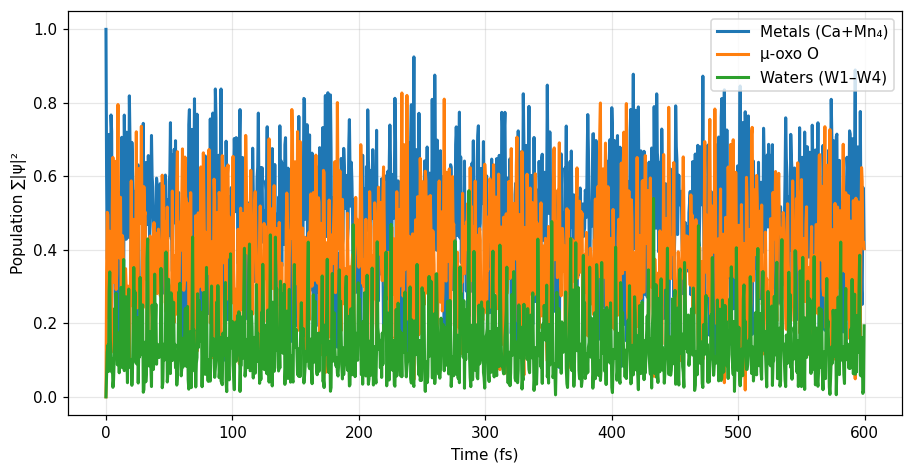

📈 saved: OEC_GQR_TDSE_MOVIE/pop_e_E1.8.png


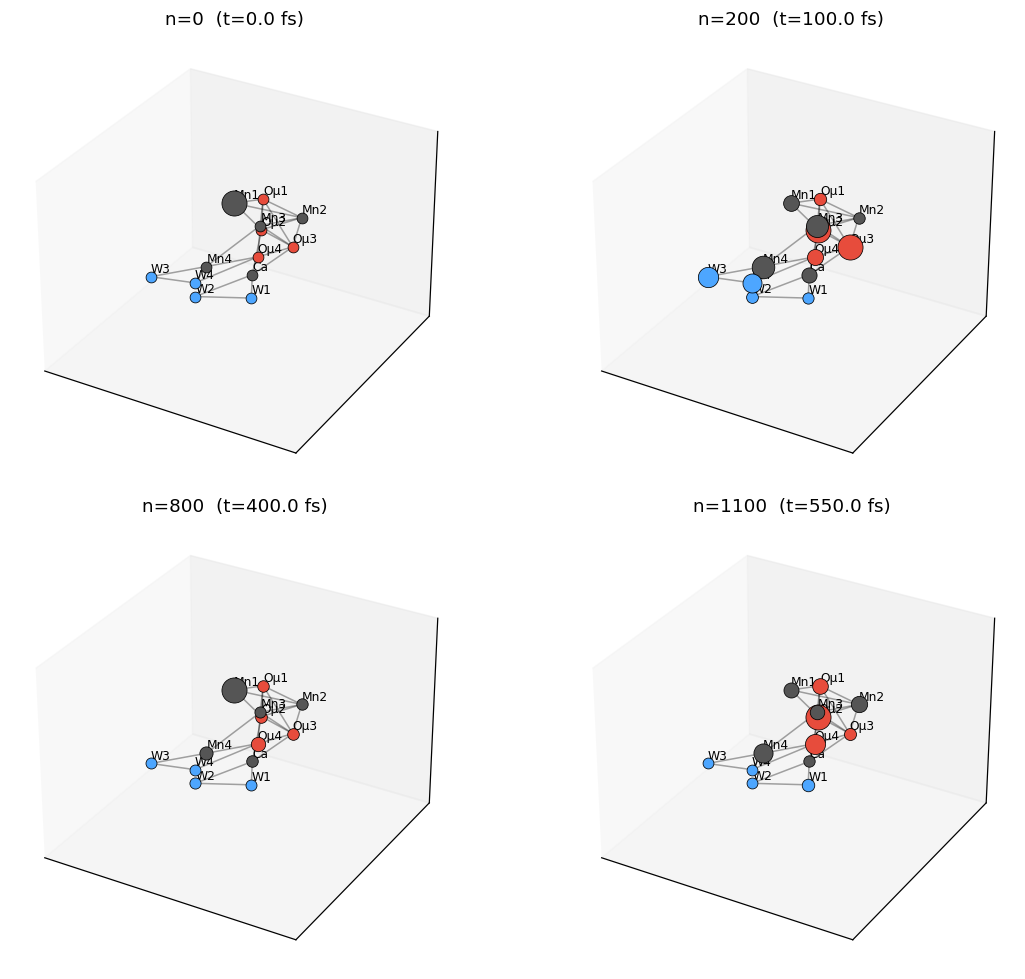

🖼 saved: OEC_GQR_TDSE_MOVIE/snapshots_e_E1.8.png
✅ geometry+time NPZ saved.


In [ ]:
# ================================================================
# OEC (3WU2.cif) → fixed-geometry GQR–TDSE with 3D MOVIE + snapshots
# - robust cubane+μ-oxo+W1–W4 extraction (cached)
# - single Hamiltonian on that graph (no re-generated geometry)
# - time-series 3D animation (node size ~ |ψ|²), plus 4-panel snapshots
# - MP4 macroblock-safe; also saves PNG frames and NPZ state
# ================================================================

# --- deps ---
!pip -q install gemmi imageio imageio-ffmpeg

import os, json, math, numpy as np, matplotlib.pyplot as plt, imageio.v2 as imageio, gemmi
from itertools import combinations

plt.rcParams['figure.dpi'] = 110

# -------------------- USER --------------------
CIF_PATH   = "3WU2.cif"   # upload once (S1, dark-adapted)
OUT_DIR    = "OEC_GQR_TDSE_MOVIE"
SPECIES    = "e"          # 'e' or 'H'
E_eV       = 1.8          # 0.0 / 0.6 / 1.8 typical
DT_FS      = 0.5          # timestep [fs]
N_STEPS    = 1200         # movie length
SNAP_STEPS = [0, 200, 800, 1100]
FPS        = 16
ROT_PER_360= 600          # frames per 360° camera orbit (nice slow spin)
SEED_JITTER= 0.0          # 0 for deterministic; e.g. 0.02 for weak disorder
# ------------------------------------------------

os.makedirs(OUT_DIR, exist_ok=True)
GEO_NPZ = os.path.join(OUT_DIR, "geometry_oec_3wu2_cached.npz")

# -------------------- small helpers --------------------
def P(a):
    p=a.pos; return np.array([p.x, p.y, p.z], float)

def set_equal(ax, pts, pad=0.8):
    pts = np.asarray(pts)
    cx,cy,cz = pts.mean(axis=0)
    r = max(np.ptp(pts, axis=0)) * 0.65 + pad
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

def pad16(img):
    h,w = img.shape[:2]
    H = (h+15)//16*16; W = (w+15)//16*16
    if (H,W)==(h,w): return img
    pad = ((0,H-h),(0,W-w),(0,0)) if img.ndim==3 else ((0,H-h),(0,W-w))
    return np.pad(img, pad, mode='edge')

# -------------------- geometry (cached) --------------------
def extract_geometry_from_cif(cif_path):
    st = gemmi.read_structure(cif_path)
    st.remove_hydrogens()
    model = st[0]

    Mn_all, Ca_all, O_all, Wat_all = [], [], [], []
    for ch in model:
        for res in ch:
            is_w = res.name.upper() in ("HOH","WAT","H2O","DOD","W")
            for a in res:
                e = a.element.name.upper()
                if e == "MN": Mn_all.append(a)
                elif e == "CA": Ca_all.append(a)
                elif e.startswith("O"):
                    (Wat_all if is_w else O_all).append(a)

    if len(Mn_all)<4 or len(Ca_all)<1:
        raise RuntimeError("Need ≥4 Mn and ≥1 Ca in 3WU2.cif")

    Mn_xyz = np.array([P(a) for a in Mn_all])
    Ca_near = [a for a in Ca_all if np.min(np.linalg.norm(Mn_xyz - P(a), axis=1)) < 6.0]
    if not Ca_near:
        cen = Mn_xyz.mean(axis=0)
        Ca_near = [min(Ca_all, key=lambda a: np.linalg.norm(P(a)-cen))]

    def cubane_cost(mset, Ca_atom):
        pts = np.array([P(m) for m in mset])
        pair = sum(np.linalg.norm(pts[i]-pts[j]) for i in range(4) for j in range(i+1,4))
        cen  = pts.mean(axis=0)
        d_ca = np.linalg.norm(cen - P(Ca_atom))
        return pair + 2.5*d_ca

    best_combo, best_cost = None, 1e9
    for Ca_atom in Ca_near:
        for combo in combinations(Mn_all, 4):
            c = cubane_cost(combo, Ca_atom)
            if c < best_cost:
                best_cost = c
                best_combo = (Ca_atom, combo)

    Ca1, Mn4 = best_combo
    metals = [Ca1] + list(Mn4)

    # μ-oxo (adaptive cutoffs)
    def find_mu_oxo(O_list, metals, t_mn=2.20, t_ca=2.55):
        found=[]
        for o in O_list:
            po = P(o); neigh=[]
            for m in metals:
                dm = np.linalg.norm(po - P(m))
                E = m.element.name.upper()
                thr = t_mn if E=="MN" else (t_ca if E=="CA" else 0)
                if dm <= thr and thr>0: neigh.append((m,dm))
            if len(neigh) >= 2:
                tot = sum(d for _,d in neigh)
                found.append((o, len(neigh), tot))
        found.sort(key=lambda t: (-t[1], t[2]))
        return [t[0] for t in found]

    muO = find_mu_oxo(O_all, metals)
    t_mn,t_ca = 2.20,2.55
    while len(muO)<4 and t_mn<2.40:
        t_mn+=0.05; t_ca+=0.05
        muO = find_mu_oxo(O_all, metals, t_mn, t_ca)
    muO = muO[:4]

    # waters: 4 closest to Ca and ≤3.0 Å to any metal
    cand=[]
    for w in (a for a in Wat_all):
        pw=P(w)
        if min(np.linalg.norm(pw - P(m)) for m in metals) <= 3.0:
            cand.append((w, np.linalg.norm(pw - P(Ca1))))
    cand.sort(key=lambda t: t[1])
    W4 = [t[0] for t in cand[:4]]

    # assemble node list
    nodes, labels, groups = [], [], []
    for i,m in enumerate(metals):
        nodes.append(P(m)); labels.append('Ca' if i==0 else f'Mn{i}'); groups.append('metal')
    for j,o in enumerate(muO,1):
        nodes.append(P(o)); labels.append(f'Oμ{j}'); groups.append('mu-oxo')
    for k,w in enumerate(W4,1):
        nodes.append(P(w)); labels.append(f'W{k}'); groups.append('water')

    return np.array(nodes), labels, groups

if os.path.exists(GEO_NPZ):
    g = np.load(GEO_NPZ, allow_pickle=True)
    nodes  = g["nodes"]
    labels = list(g["labels"])
    groups = list(g["groups"])
else:
    if not os.path.exists(CIF_PATH):
        raise FileNotFoundError("Upload 3WU2.cif first.")
    nodes, labels, groups = extract_geometry_from_cif(CIF_PATH)
    np.savez_compressed(GEO_NPZ, nodes=nodes, labels=np.array(labels,object), groups=np.array(groups,object))

N = len(nodes)
idx_metal = [i for i,g in enumerate(groups) if g=='metal']
idx_muoxo = [i for i,g in enumerate(groups) if g=='mu-oxo']
idx_water = [i for i,g in enumerate(groups) if g=='water']

# -------------------- GQR/TDSE model --------------------
# species-dependent baselines
if SPECIES == 'e':
    beta0 = 0.64; ETA_MAX=0.30; DUTY_MAX=1.9;  SIG_E0=0.30; SIG_K=4.0
else:
    beta0 = 0.77; ETA_MAX=0.38; DUTY_MAX=2.1;  SIG_E0=0.45; SIG_K=3.5

COMB_AMP, COMB_WIDTH = 3.0, 0.20
ALPHA_SH, D0_SH, P_SH = 0.14, 0.8, 2.0
T0 = 1.0

def sigmoid(x, x0, k): return 1.0/(1.0+np.exp(-k*(x-x0)))
def lorentzian(d, c, g): return (g*g)/((d-c)**2 + g*g)

def resonance_comb(r, amp, width, centers=(0.7,1.0,1.5,2.2)):
    s = 0.0
    for c in centers: s += lorentzian(r, c, width)
    s /= (np.max(s) + 1e-12) if not np.isscalar(s) else (s if s>0 else 1.0)
    return 1.0 + amp * s * np.exp(-r/3.0)

def shield_loss(r, alpha, d0, p):
    return np.clip(1.0 - alpha*np.exp(-(r/d0)**p), 1e-6, 1.0)

def gqr_gain(r, occ_ij=0.0):
    etaH  = ETA_MAX * sigmoid(E_eV, SIG_E0, SIG_K) if E_eV>0 else 0.0
    duty  = 1.0 + (DUTY_MAX-1.0)*sigmoid(E_eV, SIG_E0, SIG_K) if E_eV>0 else 1.0
    beta_eff = max(beta0*(1.0-etaH), 0.20)
    alpha_eff = ALPHA_SH*(1.0 - 0.5*occ_ij)
    return np.exp((beta0 - beta_eff)*r) * resonance_comb(r, COMB_AMP, COMB_WIDTH) * shield_loss(r, alpha_eff, D0_SH, P_SH) * duty

# precompute all plausible edges
pairs = []
for i in range(N):
    for j in range(i+1,N):
        r = np.linalg.norm(nodes[i]-nodes[j])
        if 0.5 < r <= 6.0:
            pairs.append((i,j,r))
pairs = np.array(pairs, dtype=object)

rng = np.random.default_rng(1234)
jitter = rng.normal(0.0, SEED_JITTER, size=len(pairs)) if SEED_JITTER>0 else np.zeros(len(pairs))

def build_H(psi):
    amp = np.abs(psi)
    occ = np.outer(amp, amp)
    scale = amp.max()**2 + 1e-15
    occ /= scale

    H = np.zeros((N,N), complex)
    for k,(i,j,r) in enumerate(pairs):
        g = gqr_gain(r, occ[i,j])
        tij = T0 * np.exp(-beta0*r) * g * (1.0 + jitter[k])
        H[i,j] = tij; H[j,i] = np.conj(tij)
    return H

def step_tdse(psi, dt_fs):
    H = build_H(psi)                 # Hermitian
    E, V = np.linalg.eigh(H)         # H = VEV†
    U = V @ np.diag(np.exp(-1j*E*dt_fs)) @ V.conj().T
    out = U @ psi
    out /= np.linalg.norm(out) + 1e-15
    return out

# -------------------- run + movie --------------------
psi = np.zeros(N, complex); psi[1] = 1.0   # start on Mn1 (index 1)
t_fs = np.arange(N_STEPS)*DT_FS

pop_metal = []; pop_muoxo = []; pop_water = []
snaps = {}

mp4_path = os.path.join(OUT_DIR, f"TDSE_{SPECIES}_E{E_eV:.1f}eV.mp4")
writer = imageio.get_writer(mp4_path, fps=FPS, codec="libx264", quality=7)

fig = plt.figure(figsize=(7,6))
ax  = fig.add_subplot(111, projection='3d')

def draw_frame(ax, amp2, title, azim):
    ax.cla()
    cols = []
    for g in groups:
        cols.append('#555' if g=='metal' else ('#E74C3C' if g=='mu-oxo' else '#4DA6FF'))
    s = 220*(amp2/(amp2.max()+1e-15)) + 50
    for i in range(N):
        x,y,z = nodes[i]
        ax.scatter([x],[y],[z], s=s[i], c=cols[i], ec='k', lw=0.5, alpha=0.95)
        ax.text(x,y,z+0.22, labels[i], fontsize=8)
    # light edges (≤3.2 Å) for context
    for (i,j,r) in pairs:
        if r<=3.2:
            xi,yi,zi = nodes[i]; xj,yj,zj = nodes[j]
            ax.plot([xi,xj],[yi,yj],[zi,zj], color='k', lw=1.0, alpha=0.35)
    ax.set_title(title)
    set_equal(ax, nodes)
    ax.view_init(elev=18, azim=azim)

for n in range(N_STEPS):
    amp2 = np.abs(psi)**2
    pop_metal.append(amp2[idx_metal].sum())
    pop_muoxo.append(amp2[idx_muoxo].sum())
    pop_water.append(amp2[idx_water].sum())
    if n in SNAP_STEPS:
        snaps[n] = amp2.copy()

    # draw & grab frame
    az = (360.0 * n / max(1,ROT_PER_360)) % 360.0
    draw_frame(ax, amp2, f"GQR–TDSE on OEC cubane  |  {SPECIES}, E={E_eV:.1f} eV  |  t={t_fs[n]:.1f} fs", az)
    fig.canvas.draw()
    img = np.asarray(fig.canvas.buffer_rgba())[:,:,:3]
    writer.append_data(pad16(img))

    psi = step_tdse(psi, DT_FS)

writer.close(); plt.close(fig)
print("🎥 saved:", mp4_path)

# populations vs time
plt.figure(figsize=(8.4,4.4))
plt.plot(t_fs, pop_metal,  lw=2.0, label='Metals (Ca+Mn₄)')
plt.plot(t_fs, pop_muoxo, lw=2.0, label='μ-oxo O')
plt.plot(t_fs, pop_water, lw=2.0, label='Waters (W1–W4)')
plt.xlabel("Time (fs)"); plt.ylabel("Population ∑|ψ|²")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
pop_png = os.path.join(OUT_DIR, f"pop_{SPECIES}_E{E_eV:.1f}.png")
plt.savefig(pop_png, dpi=130); plt.show()
print("📈 saved:", pop_png)

# snapshots panel
fig = plt.figure(figsize=(11,9))
rows = int(np.ceil(len(SNAP_STEPS)/2))
for k,n in enumerate(SNAP_STEPS, start=1):
    ax = fig.add_subplot(rows,2,k, projection='3d')
    s = 220*(snaps[n]/(snaps[n].max()+1e-15))+50
    cols=[]
    for g in groups: cols.append('#555' if g=='metal' else ('#E74C3C' if g=='mu-oxo' else '#4DA6FF'))
    for i in range(N):
        x,y,z = nodes[i]
        ax.scatter([x],[y],[z], s=s[i], c=cols[i], ec='k', lw=0.5)
        ax.text(x,y,z+0.22, labels[i], fontsize=8)
    for (i,j,r) in pairs:
        if r<=3.2:
            xi,yi,zi = nodes[i]; xj,yj,zj = nodes[j]
            ax.plot([xi,xj],[yi,yj],[zi,zj], color='k', lw=1.0, alpha=0.35)
    ax.set_title(f"n={n}  (t={t_fs[n]:.1f} fs)")
    set_equal(ax, nodes)
plt.tight_layout()
snap_png = os.path.join(OUT_DIR, f"snapshots_{SPECIES}_E{E_eV:.1f}.png")
plt.savefig(snap_png, dpi=130); plt.show()
print("🖼 saved:", snap_png)

# state dump
np.savez_compressed(os.path.join(OUT_DIR, f"state_{SPECIES}_E{E_eV:.1f}.npz"),
                    nodes=nodes, labels=np.array(labels,object), groups=np.array(groups,object),
                    t=t_fs, pop_metal=np.array(pop_metal),
                    pop_muoxo=np.array(pop_muoxo), pop_water=np.array(pop_water),
                    snaps=snaps, pairs=pairs)
print("✅ geometry+time NPZ saved.")

---- DIAGNOSTIC ----
Metals (expect Ca + 4 Mn): ['Ca', 'Mn', 'Mn', 'Mn', 'Mn']
Inter-metal distances (Å):
  Ca–Mn1: 3.49
  Ca–Mn2: 3.30
  Ca–Mn3: 3.41
  Ca–Mn4: 3.80
  Mn1–Mn2: 2.76
  Mn1–Mn3: 3.29
  Mn1–Mn4: 4.92
  Mn2–Mn3: 2.92
  Mn2–Mn4: 5.38
  Mn3–Mn4: 2.89
μ-O selected: 4  (Mn–O≤2.20 Å, Ca–O≤2.55 Å)
  O1: Mn:1.93, Mn:2.02, Mn:1.86
  O2: Ca:2.44, Mn:1.80, Mn:2.07
  O3: Ca:2.48, Mn:1.96, Mn:1.91
  O4: Mn:2.06, Mn:2.05
Waters picked: ['O:52622', 'O:52693', 'O:52650', 'O:52682']
Hydrogens per water: 2 (constructed)


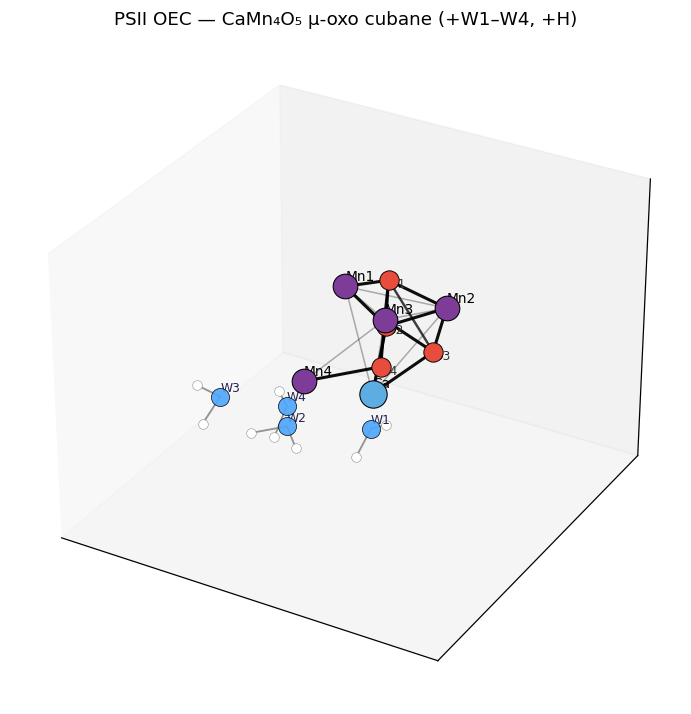

✅ Saved OEC_OVERVIEW.png


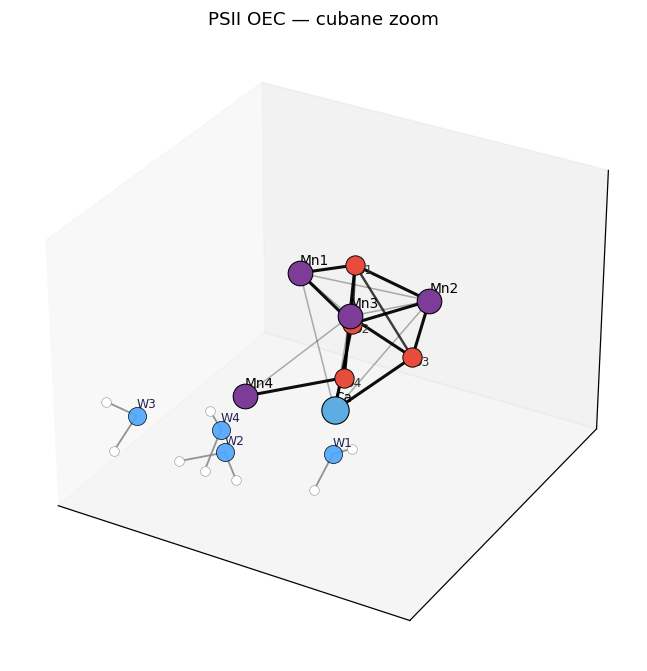

✅ Saved OEC_ZOOM.png


In [ ]:
# [001] ================================================================
# [002] OEC (3WU2.cif) — CaMn4O5 μ-oxo cubane + waters (+ explicit H)
# [003] Colors: Ca = light blue, Mn = purple, μ-oxo O = red,
# [004]          Waters O = light blue, Waters H = white
# [005] Bonds:   M–μO, μO–μO (cubane edges), shared Mn–Mn (faint), O–H
# [006] Outputs: OEC_OVERVIEW.png, OEC_ZOOM.png
# [007] ================================================================
!pip -q install gemmi

# [010] ---------- Imports ----------
import os, math
import numpy as np
import matplotlib.pyplot as plt
import gemmi
from itertools import combinations

# [020] ---------- User settings ----------
CIF_PATH   = "3WU2.cif"   # upload first in Colab (Files panel) or place alongside this notebook
OUT_OV     = "OEC_OVERVIEW.png"
OUT_ZM     = "OEC_ZOOM.png"
ZOOM_R     = 4.0          # Å, radius for zoom panel around metal centroid
DRAW_SHARED_MN = True     # draw faint Mn–Mn edges if they share a μ-O
ADD_WATER_H   = True      # attach 2 hydrogens to each selected water
H_O_BOND      = 0.97      # Å, O–H bond length
HOH_ANGLE     = 104.5     # degrees, gas-phase water angle (good enough for viz)

# [035] ---------- Helpers ----------
def P(a):
    """Return gemmi atom position as np.array([x,y,z])."""
    p = a.pos
    return np.array([p.x, p.y, p.z], float)

def set_equal_3d(ax, pts, pad=0.8):
    """Equal aspect 3D with NumPy 2.0-safe ptp."""
    pts = np.asarray(pts, float)
    cx, cy, cz = pts.mean(axis=0)
    r = max(np.ptp(pts, axis=0)) * 0.65 + pad
    ax.set_xlim(cx - r, cx + r)
    ax.set_ylim(cy - r, cy + r)
    ax.set_zlim(cz - r, cz + r)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

def norm(v):
    v = np.asarray(v, float)
    n = np.linalg.norm(v)
    return v / (n + 1e-12)

def rot_about_axis(v, axis, angle_rad):
    """Rotate vector v around 'axis' by angle (rad)."""
    axis = norm(axis)
    c, s = math.cos(angle_rad), math.sin(angle_rad)
    vx, vy, vz = v
    ax, ay, az = axis
    # Rodrigues' rotation formula
    return (v * c +
            np.cross(axis, v) * s +
            axis * (np.dot(axis, v) * (1 - c)))

# [070] ---------- Load structure ----------
if not os.path.exists(CIF_PATH):
    raise FileNotFoundError("Upload 3WU2.cif first (dark-adapted S1).")

st = gemmi.read_structure(CIF_PATH)
st.remove_hydrogens()
model = st[0]

Mn_all, Ca_all, O_all, Wat_all = [], [], [], []
for ch in model:
    for res in ch:
        is_w = res.name.upper() in ("HOH", "WAT", "H2O", "DOD", "W")
        for a in res:
            e = a.element.name.upper()
            if   e == "MN": Mn_all.append(a)
            elif e == "CA": Ca_all.append(a)
            elif e.startswith("O"):
                (Wat_all if is_w else O_all).append(a)

if len(Mn_all) < 4 or len(Ca_all) < 1:
    raise RuntimeError("Could not find Ca + ≥4 Mn in 3WU2.cif")

# [100] ---------- Choose Ca + best Mn4 (single asymmetric unit; compact to Ca) ----------
Mn_xyz = np.array([P(a) for a in Mn_all])
# Ca near Mn cluster (same unit): near any Mn within 6 Å
Ca_near = [a for a in Ca_all if np.min(np.linalg.norm(Mn_xyz - P(a), axis=1)) < 6.0]
if not Ca_near:
    cen = Mn_xyz.mean(axis=0)
    Ca_near = [min(Ca_all, key=lambda a: np.linalg.norm(P(a) - cen))]

def cubane_cost(mns, Ca_atom):
    pts = np.array([P(m) for m in mns])
    pair_sum = sum(np.linalg.norm(pts[i]-pts[j])
                   for i in range(4) for j in range(i+1,4))
    cen  = pts.mean(axis=0)
    d_ca = np.linalg.norm(cen - P(Ca_atom))
    return pair_sum + 2.5 * d_ca

best, best_cost = None, 1e9
for ca in Ca_near:
    for combo in combinations(Mn_all, 4):
        c = cubane_cost(combo, ca)
        if c < best_cost:
            best_cost = c
            best = (ca, combo)

Ca1, Mn4 = best
Mn4 = list(Mn4)
metals = [Ca1] + Mn4
met_pts = [P(m) for m in metals]
met_names = ["Ca"] + [f"Mn{i}" for i in range(1,5)]

# [140] ---------- Find μ-oxo (needs ≥2 metal neighbors within thresholds) ----------
def find_mu_oxo(O_list, metals, thr_mn=2.20, thr_ca=2.55):
    hits = []
    for o in O_list:
        po = P(o)
        neigh, tot = [], 0.0
        for m in metals:
            dm = np.linalg.norm(po - P(m))
            is_mn = (m.element.name.upper() == "MN")
            is_ca = (m.element.name.upper() == "CA")
            if (is_mn and dm <= thr_mn) or (is_ca and dm <= thr_ca):
                neigh.append((m, dm))
                tot += dm
        if len(neigh) >= 2:
            hits.append((o, len(neigh), tot))
    # prioritize higher coordination, then shorter distances
    hits.sort(key=lambda t: (-t[1], t[2]))
    return [t[0] for t in hits]

thr_mn_o, thr_ca_o = 2.20, 2.55
muO = find_mu_oxo(O_all, metals, thr_mn_o, thr_ca_o)
while len(muO) < 4 and thr_mn_o < 2.40:
    thr_mn_o += 0.05; thr_ca_o += 0.05
    muO = find_mu_oxo(O_all, metals, thr_mn_o, thr_ca_o)
muO = muO[:4]

# [170] ---------- Choose four waters (closest to Ca; within 3.0 Å of any metal) ----------
cand = []
for w in Wat_all:
    pw = P(w)
    if min(np.linalg.norm(pw - P(m)) for m in metals) <= 3.0:
        cand.append((w, np.linalg.norm(pw - P(Ca1))))
cand.sort(key=lambda t: t[1])
W4 = [t[0] for t in cand[:4]]

# [190] ---------- Attach hydrogens to waters (simple geometry) ----------
# Strategy: for each water O at Ow, define a base direction pointing *away* from metal centroid
# then rotate by ±(HOH_ANGLE/2) around a perpendicular axis to create two O–H vectors.
def place_water_hydrogens(Ow, ref_dir, oh=H_O_BOND, angle_deg=HOH_ANGLE):
    """Return two hydrogen positions for a water oxygen at Ow, given a reference direction."""
    Ow = np.asarray(Ow, float)
    d0 = norm(ref_dir)
    # pick a perpendicular axis (stable even if d0 ~ z)
    if abs(d0[2]) < 0.9:
        perp = norm(np.cross(d0, np.array([0,0,1.0])))
    else:
        perp = norm(np.cross(d0, np.array([0,1.0,0])))
    half = math.radians(angle_deg / 2.0)
    v1 = rot_about_axis(d0, perp, +half)
    v2 = rot_about_axis(d0, perp, -half)
    H1 = Ow + oh * v1
    H2 = Ow + oh * v2
    return H1, H2

H_positions = []  # list of (H_xyz, parent_water_index)
if ADD_WATER_H:
    metal_centroid = np.mean(np.array([P(m) for m in metals]), axis=0)
    for wi, w in enumerate(W4):
        Ow = P(w)
        ref = norm(Ow - metal_centroid)  # point away from metal cluster
        H1, H2 = place_water_hydrogens(Ow, ref, H_O_BOND, HOH_ANGLE)
        H_positions.append((H1, wi))
        H_positions.append((H2, wi))

# [230] ---------- Build connectivity (for drawing bonds) ----------
def metal_muO_edges(metals, muO, thr_mn, thr_ca):
    edges = []
    for i, m in enumerate(metals):
        is_mn = (m.element.name.upper() == "MN")
        thr   = thr_mn if is_mn else thr_ca
        pm = P(m)
        for j, o in enumerate(muO):
            if np.linalg.norm(pm - P(o)) <= thr:
                edges.append((i, j))
    return edges

def shared_mn_edges(metals, muO, M_O_edges):
    # If two metals share at least one μ-O, link them faintly
    mm = set()
    for i, j in combinations(range(len(metals)), 2):
        shared = any(((i,k) in M_O_edges) and ((j,k) in M_O_edges)
                     for k in range(len(muO)))
        if shared:
            mm.add((i, j))
    return list(mm)

def muO_muO_edges(muO):
    # Heuristic: connect μ-Ox that are within ~2.9 Å (typical bridge)
    edges = []
    for i, j in combinations(range(len(muO)), 2):
        if np.linalg.norm(P(muO[i]) - P(muO[j])) <= 2.9:
            edges.append((i, j))
    return edges

M_O_edges = metal_muO_edges(metals, muO, thr_mn_o, thr_ca_o)
MM_edges  = shared_mn_edges(metals, muO, M_O_edges) if DRAW_SHARED_MN else []
OO_edges  = muO_muO_edges(muO)

# [270] ---------- Diagnostics ----------
def lab_atom(a):
    e = a.element.name
    try:
        sid = int(a.serial)
        return f"{e}:{sid}"
    except Exception:
        return f"{e}"

print("---- DIAGNOSTIC ----")
print("Metals (expect Ca + 4 Mn):", [m.element.name for m in metals])
print("Inter-metal distances (Å):")
for i, j in combinations(range(len(metals)), 2):
    di = np.linalg.norm(P(metals[i]) - P(metals[j]))
    print(f"  {met_names[i]}–{met_names[j]}: {di:.2f}")
print(f"μ-O selected: {len(muO)}  (Mn–O≤{thr_mn_o:.2f} Å, Ca–O≤{thr_ca_o:.2f} Å)")
for k, o in enumerate(muO, 1):
    neigh = []
    po = P(o)
    for m in metals:
        dm = np.linalg.norm(po - P(m))
        if (m.element.name.upper()=="MN" and dm<=thr_mn_o) or \
           (m.element.name.upper()=="CA" and dm<=thr_ca_o):
            neigh.append(f"{m.element.name}:{dm:.2f}")
    print(f"  O{k}: {', '.join(neigh)}")
print("Waters picked:", [lab_atom(w) for w in W4])
if ADD_WATER_H:
    print("Hydrogens per water: 2 (constructed)")

# [310] ---------- Plotting ----------
COL = {
    "CA": "#5DADE2",    # Ca light-blue
    "MN": "#7D3C98",    # Mn purple
    "Oμ": "#E74C3C",    # μ-oxo oxygen red
    "OW": "#4DA6FF",    # water oxygen light-blue
    "H" : "#FFFFFF"     # water hydrogens white
}

SZ  = {
    "CA": 320,
    "MN": 260,
    "Oμ": 160,
    "OW": 140,
    "H" : 40
}

def draw_scene(ax, title, zoom=None):
    pts = []

    # metals
    for i, m in enumerate(metals):
        X = P(m); E = m.element.name.upper()
        col = COL["CA"] if E == "CA" else COL["MN"]
        siz = SZ["CA"]  if E == "CA" else SZ["MN"]
        ax.scatter([X[0]],[X[1]],[X[2]], s=siz, c=col, ec="k", lw=0.7)
        ax.text(X[0], X[1], X[2]+0.25, "Ca" if E=="CA" else f"Mn{i}", fontsize=9)
        pts.append(X)

    # μ-oxo
    for j, o in enumerate(muO, 1):
        X = P(o)
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ["Oμ"], c=COL["Oμ"], ec="k", lw=0.6)
        ax.text(X[0], X[1], X[2]-0.28, f"O{j}", fontsize=8, color="#333")
        pts.append(X)

    # water O
    for k, w in enumerate(W4, 1):
        X = P(w)
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ["OW"], c=COL["OW"], ec="k", lw=0.5, alpha=0.9)
        ax.text(X[0], X[1], X[2]+0.22, f"W{k}", fontsize=8, color="#225")
        pts.append(X)

    # water H + O–H bonds
    if ADD_WATER_H and H_positions:
        for (Hxyz, wi) in H_positions:
            x,y,z = Hxyz
            ax.scatter([x],[y],[z], s=SZ["H"], c=COL["H"], ec="#999", lw=0.4, alpha=1.0)
            # O–H bond
            Ow = P(W4[wi])
            ax.plot([Ow[0], x], [Ow[1], y], [Ow[2], z], color="#888", lw=1.2, alpha=0.9)

    # M–μO bonds (solid)
    for (i, j) in M_O_edges:
        A = P(metals[i]); B = P(muO[j])
        ax.plot([A[0],B[0]],[A[1],B[1]],[A[2],B[2]], color="k", lw=2.0, alpha=0.95)

    # μO–μO edges (cubane-ish)
    for (i, j) in OO_edges:
        A = P(muO[i]); B = P(muO[j])
        ax.plot([A[0],B[0]],[A[1],B[1]],[A[2],B[2]], color="k", lw=1.6, alpha=0.75)

    # Shared Mn–Mn (faint)
    if DRAW_SHARED_MN:
        for (i, j) in MM_edges:
            A = P(metals[i]); B = P(metals[j])
            ax.plot([A[0],B[0]],[A[1],B[1]],[A[2],B[2]], color="k", lw=1.0, alpha=0.3)

    ax.set_title(title)
    if zoom is None:
        set_equal_3d(ax, pts)
    else:
        cx, cy, cz, r = zoom
        ax.set_xlim(cx - r, cx + r)
        ax.set_ylim(cy - r, cy + r)
        ax.set_zlim(cz - r, cz + r)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# [400] ---------- Render + save ----------
# Overview
fig = plt.figure(figsize=(8.0, 6.6))
ax  = fig.add_subplot(111, projection="3d")
draw_scene(ax, "PSII OEC — CaMn₄O₅ μ-oxo cubane (+W1–W4, +H)")
plt.tight_layout(); plt.savefig(OUT_OV, dpi=300); plt.show()
print(f"✅ Saved {OUT_OV}")

# Zoom
cen = np.mean(np.array([P(m) for m in metals]), axis=0)
fig2 = plt.figure(figsize=(6.8, 6.2))
ax2  = fig2.add_subplot(111, projection="3d")
draw_scene(ax2, "PSII OEC — cubane zoom", zoom=(cen[0], cen[1], cen[2], ZOOM_R))
plt.tight_layout(); plt.savefig(OUT_ZM, dpi=300); plt.show()
print(f"✅ Saved {OUT_ZM}")